# Statystyczne Reguły Decyzyjne
## Projekt: analiza zbioru Adult
Laura Hoang 140381

Jan Wojnowski 140701

Palina Ionina 140200

### 1. Wprowadzanie i opis problemu

W ramach niniejszego projektu rozważany jest problem klasyfikacji binarnej, polegający na przewidywaniu poziomu dochodu osoby fizycznej na podstawie danych pochodzących ze spisu ludności. Do realizacji zadania wykorzystano klasyczny zbiór danych **Adult (Census Income)**, który stanowi standardowy punkt odniesienia w badaniach nad metodami klasyfikacyjnymi oraz regułami decyzyjnymi.

Rozpatrywany problem decyzyjny polega na **przewidywaniu, czy roczny dochód danej osoby przekracza 50 000 dolarów amerykańskich**, na podstawie zestawu jej cech demograficznych i ekonomicznych, pochodzących z danych spisowych. Formalnie jest to zadanie **klasyfikacji binarnej**, w którym każdej obserwacji przypisywana jest jedna z dwóch możliwych klas decyzyjnych:

* dochód **nieprzekraczający 50 000 USD rocznie** (`<=50K`),
* dochód **przekraczający 50 000 USD rocznie** (`>50K`).

Zmienna decyzyjna `income` stanowi etykietę klasy, natomiast pozostałe zmienne opisowe tworzą przestrzeń cech, na podstawie której konstruowany jest model klasyfikacyjny. Obejmują one m.in. wiek, poziom wykształcenia, formę zatrudnienia, wykonywany zawód, stan cywilny, liczbę przepracowanych godzin tygodniowo, a także cechy demograficzne takie jak płeć, rasa czy kraj pochodzenia.

Celem analizy jest wyznaczenie takiej reguły decyzyjnej, która na podstawie obserwowanego wektora cech maksymalizuje prawdopodobieństwo poprawnej klasyfikacji dochodu danej osoby. Problem ten ma istotne znaczenie praktyczne, ponieważ pozwala analizować zależności pomiędzy cechami demograficznymi a poziomem dochodów, a jednocześnie stanowi dobre studium przypadku do porównywania różnych metod klasyfikacji statystycznej.

Z punktu widzenia teorii statystycznych reguł decyzyjnych, zadanie to może być rozpatrywane jako problem minimalizacji ryzyka klasyfikacyjnego przy zadanej funkcji straty, co umożliwia formalną ocenę jakości zastosowanych modeli oraz porównanie ich skuteczności.

In [1]:
# pobranie potrzebnych bibliotek
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ucimlrepo import fetch_ucirepo  # biblioteka z danymi

import warnings
warnings.filterwarnings("ignore")

In [2]:
adult = fetch_ucirepo(id=2)  # zbiór danych

### 2. Opis zbioru danych

W projekcie wykorzystano zbiór danych **Adult** (znany również jako **Census Income Dataset**), pochodzący z repozytorium **UCI Machine Learning Repository**. Zbiór ten został opracowany na podstawie danych spisowych z **1994 roku**, a jego ekstrakcję przeprowadzili **Barry Becker** oraz **Ronny Kohavi**. Dane zostały opublikowane w **1996 roku**, a ich najnowsza aktualizacja miała miejsce **24 września 2024 roku**. Zbiór posiada identyfikator DOI: *10.24432/C5XW20*.

Celem zbioru danych jest rozwiązanie zadania **klasyfikacji binarnej**, polegającego na przewidywaniu, czy **roczny dochód danej osoby przekracza 50 000 USD**. Zmienna decyzyjna (`income`) przyjmuje dwie wartości: `>50K` oraz `<=50K`.

Zbiór danych należy do obszaru **nauk społecznych** i ma charakter **wielowymiarowy (multivariate)**. Składa się z **48 842 obserwacji** oraz **14 zmiennych objaśniających**, opisujących cechy demograficzne i ekonomiczne badanych osób. Zmienne mają charakter **liczbowy (integer)** oraz **kategoryczny** i obejmują informacje dotyczące m.in. wieku, poziomu wykształcenia, sytuacji zawodowej, stanu cywilnego, rasy, płci oraz liczby przepracowanych godzin w tygodniu.

Podczas ekstrakcji danych zastosowano zestaw warunków filtrujących w celu uzyskania względnie jednorodnego i „czystego” zbioru obserwacji. Do zbioru włączono jedynie rekordy spełniające następujące kryteria:

* wiek powyżej 16 lat,
* dochód brutto powyżej 100 USD,
* waga populacyjna (`fnlwgt`) większa od 1,
* liczba godzin pracy w tygodniu większa od 0.

W zbiorze danych występują **braki danych**, oznaczone symbolem `NaN`, głównie w zmiennych kategorycznych takich jak `workclass`, `occupation` oraz `native-country`.

**Rozkład zmiennej celu:**
Zbiór charakteryzuje się umiarkowanym niezbalansowaniem klas. Klasa mniejszościowa (`>50K`) stanowi około **24%** obserwacji, podczas gdy klasa większościowa (`<=50K`) obejmuje około **76%** rekordów. Ta asymetria zostanie uwzględniona przy wyborze metryk oceny modeli.

| Zmienna            | Rola         | Typ danych   | Demografia           | Opis wartości                                                    | Braki danych |
| ------------------ | ------------ | ------------ | -------------------- | ---------------------------------------------------------------- | ------------ |
| **age**            | Cecha        | Liczbowa     | Wiek                 | *(brak)*                                                         | nie          |
| **workclass**      | Cecha        | Kategoryczna | Zarobki              | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov… | tak          |
| **fnlwgt**         | Cecha        | Liczbowa     | *(brak)*             | *(brak)*                                                         | nie          |
| **education**      | Cecha        | Kategoryczna | Poziom Wykształcenia | Bachelors, Some-college, 11th, HS-grad, Prof-school, …           | nie          |
| **education-num**  | Cecha        | Liczbowa     | Poziom Wykształcenia | *(brak)*                                                         | nie          |
| **marital-status** | Cecha        | Kategoryczna | Inne                 | Married-civ-spouse, Divorced, Never-married, Separated, …        | nie          |
| **occupation**     | Cecha        | Kategoryczna | Inne                 | Tech-support, Craft-repair, Other-service, Sales, …              | tak          |
| **relationship**   | Cecha        | Kategoryczna | Inne                 | Wife, Own-child, Husband, Not-in-family, Other-relative, …       | nie          |
| **race**           | Cecha        | Kategoryczna | Rasa                 | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black      | nie          |
| **sex**            | Cecha        | Binarna      | Płeć                 | Female, Male                                                     | nie          |
| **capital-gain**   | Cecha        | Liczbowa     | *(brak)*             | *(brak)*                                                         | nie          |
| **capital-loss**   | Cecha        | Liczbowa     | *(brak)*             | *(brak)*                                                         | nie          |
| **hours-per-week** | Cecha        | Liczbowa     | *(brak)*             | *(brak)*                                                         | nie          |
| **native-country** | Cecha        | Kategoryczna | Inne                 | United-States, Cambodia, England, Puerto-Rico, Canada, …         | tak          |
| **income**         | Zmienna celu | Binarna      | Zarobki              | >50K, <=50K                                                      | nie          |


In [3]:
X = adult.data.features
y = adult.data.targets

df_adult = X.copy()
df_adult["income"] = y
df_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 3. Czyszczenie i wstępne przetwarzanie danych
Czyszczenie i wstępne przetwarzanie danych - imputacja braków danych, standaryzacja, kodowanie typu one-hot, transformacja wartości odstających, itp.

In [4]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


#### 3.1. Identyfikacja i analiza braków danych

Wstępna weryfikacja zbioru danych wykazała obecność niestandardowych oznaczeń braków danych (znak `?`) w zmiennych kategorycznych: `workclass`, `occupation` oraz `native-country`. Przed przystąpieniem do analizy dokonano unifikacji oznaczeń do formatu `NaN`. Poniżej przedstawiono statystyki braków oraz zbadano ich wpływ na zmienną celu, aby dobrać odpowiednią metodę imputacji.


In [5]:
cols_wmiss = ['workclass', 'occupation', 'native-country']

# Standaryzacja braków danych (zamiana '?' na np.bnan)
df_adult = df_adult.replace('?', np.nan)

missing_stats = df_adult[cols_wmiss].isnull().sum().to_frame(name='Liczba braków')
missing_stats['Procent braków'] = (missing_stats['Liczba braków'] / len(df_adult)) * 100
print("Statystyki braków danych przed imputacją:")
print(missing_stats)

overlap = (df_adult['workclass'].isna() & df_adult['occupation'].isna()).sum()
print(f"\nLiczba rekordów z brakiem jednocześnie w 'workclass' i 'occupation': {overlap}")

# Weryfikacja nielosowości braków
mask_missing_workclass = df_adult['workclass'].isna()

pct_miss = (df_adult[mask_missing_workclass]['income'] == '>50K').mean() * 100
pct_nomiss = (df_adult[~mask_missing_workclass]['income'] == '>50K').mean() * 100

print(f"\nAnaliza wpływu braków na zmienną celu (income >50K):")
print(f" - Grupa z brakami w workclass: {pct_miss:.2f}%")
print(f" - Grupa bez braków:            {pct_nomiss:.2f}%")
print(" Wniosek: Braki są skorelowane z niższym dochodem (MNAR).")

Statystyki braków danych przed imputacją:
                Liczba braków  Procent braków
workclass                2799        5.730724
occupation               2809        5.751198
native-country            857        1.754637

Liczba rekordów z brakiem jednocześnie w 'workclass' i 'occupation': 2799

Analiza wpływu braków na zmienną celu (income >50K):
 - Grupa z brakami w workclass: 6.82%
 - Grupa bez braków:            16.61%
 Wniosek: Braki są skorelowane z niższym dochodem (MNAR).



**Wnioski i decyzja o imputacji**

Przeprowadzona analiza wykazała silną współzależność między brakami w zmiennych `workclass` i `occupation`. Co ważniejsze, analiza rozkładu zmiennej decyzyjnej ujawniła, że grupa osób z brakującymi danymi charakteryzuje się znacznie niższym odsetkiem osób zamożnych (>50K) w porównaniu do reszty populacji.

Sugeruje to, że braki te nie są błędem losowym, lecz niosą istotną informację semantyczną – najprawdopodobniej dotyczą osób bezrobotnych lub nigdy niepracujących. Z tego względu odrzucono metody usuwania obserwacji oraz imputacji najczęstszą wartością. Zdecydowano się na **utworzenie nowej kategorii 'Unknown'**, co pozwoli modelowi wykorzystać informację o braku danych jako cechę predykcyjną.


In [6]:
# Implementacja decyzji: Imputacja stałą wartością 'Unknown'
for col in cols_wmiss:
    df_adult[col] = df_adult[col].fillna('Unknown')

print("Imputacja zakończona pomyślnie. Nowa liczba braków:")
print(df_adult[cols_wmiss].isnull().sum())

Imputacja zakończona pomyślnie. Nowa liczba braków:
workclass         0
occupation        0
native-country    0
dtype: int64


#### 3.2. Kodowanie zmiennych kategorycznych
W zbiorze zawartych jest 7 zmiennych kategorycznych: `workclass`, `education`, `marital-status`, `occupation`, `relationship`, `race`, `sex`, `native-country`.

##### 3.2.1. Zmienna workclass

In [7]:
# Sprawdzenie liczności kategorii w workclass
wc_counts = df_adult['workclass'].value_counts()
print(wc_counts)

# Sprawdzenie udziału procentowego
print("\nUdział procentowy:")
print(df_adult['workclass'].value_counts(normalize=True) * 100)

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
Unknown              2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

Udział procentowy:
workclass
Private             69.419762
Self-emp-not-inc     7.907129
Local-gov            6.420703
Unknown              5.730724
State-gov            4.055935
Self-emp-inc         3.470374
Federal-gov          2.931903
Without-pay          0.042996
Never-worked         0.020474
Name: proportion, dtype: float64


Zmienna `workclass` posiada 9 unikalnych kategorii (wliczając `Unknown`). Analiza rozkładu wskazuje na silną dominację sektora prywatnego oraz występowanie klas o marginalnej liczności takich jak `Without-pay` czy `Never-worked`. Mimo dużego niezbalansowania, zdecydowano się zachować pełną szczegółowość danych i przekształcić zmienną metodą One-Hot Encoding.

In [8]:
# Kodowanie zmiennej workclass
df_adult = pd.get_dummies(df_adult, columns=['workclass'], drop_first=True, dtype=int)
df_adult.head()

,age,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,...,native-country,income,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay
0,39,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,...,United-States,<=50K,0,0,0,0,0,1,0,0
1,50,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,...,United-States,<=50K,0,0,0,0,1,0,0,0
2,38,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,...,United-States,<=50K,0,0,1,0,0,0,0,0
3,53,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,...,United-States,<=50K,0,0,1,0,0,0,0,0
4,28,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,...,Cuba,<=50K,0,0,1,0,0,0,0,0


##### 3.2.2. Zmienna education
Zbiór zawiera dwie zmienne o tym samym znaczeniu: `education` oraz `education-num`.

In [9]:
df_adult.loc[:, ['education', 'education-num']].drop_duplicates().sort_values(by='education-num')

,education,education-num
224,Preschool,1
160,1st-4th,2
56,5th-6th,3
15,7th-8th,4
6,9th,5
77,10th,6
3,11th,7
415,12th,8
2,HS-grad,9
10,Some-college,10


Zmienna `education-num` zachowuje porządkowość zmiennej `education`, zatem usunięta zostanie ta druga.

In [10]:
df_adult = df_adult.drop(columns=['education'])

##### 3.2.3. Zmienna marital-status

In [11]:
# Sprawdzenie liczności kategorii w marital-status
ms_counts = df_adult['marital-status'].value_counts()
print(ms_counts)

# Sprawdzenie udziału procentowego
print("\nUdział procentowy:")
print(df_adult['marital-status'].value_counts(normalize=True) * 100)

marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64

Udział procentowy:
marital-status
Married-civ-spouse       45.819172
Never-married            32.998239
Divorced                 13.580525
Separated                 3.132550
Widowed                   3.107981
Married-spouse-absent     1.285779
Married-AF-spouse         0.075754
Name: proportion, dtype: float64


In [12]:
df_adult = pd.get_dummies(df_adult, columns=['marital-status'], drop_first=True, dtype=int)
df_adult.head()

,age,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,...,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed
0,39,77516,13,Adm-clerical,Not-in-family,White,Male,2174,0,40,...,0,1,0,0,0,0,0,1,0,0
1,50,83311,13,Exec-managerial,Husband,White,Male,0,0,13,...,1,0,0,0,0,1,0,0,0,0
2,38,215646,9,Handlers-cleaners,Not-in-family,White,Male,0,0,40,...,0,0,0,0,0,0,0,0,0,0
3,53,234721,7,Handlers-cleaners,Husband,Black,Male,0,0,40,...,0,0,0,0,0,1,0,0,0,0
4,28,338409,13,Prof-specialty,Wife,Black,Female,0,0,40,...,0,0,0,0,0,1,0,0,0,0


##### 3.2.4. Zmienna relationship

In [13]:
# Sprawdzenie liczności kategorii w relationship
ms_counts = df_adult['relationship'].value_counts()
print(ms_counts)

# Sprawdzenie udziału procentowego
print("\nUdział procentowy:")
print(df_adult['relationship'].value_counts(normalize=True) * 100)

relationship
Husband           19716
Not-in-family     12583
Own-child          7581
Unmarried          5125
Wife               2331
Other-relative     1506
Name: count, dtype: int64

Udział procentowy:
relationship
Husband           40.366897
Not-in-family     25.762663
Own-child         15.521477
Unmarried         10.493018
Wife               4.772532
Other-relative     3.083412
Name: proportion, dtype: float64


In [14]:
df_adult = pd.get_dummies(df_adult, columns=['relationship'], drop_first=True, dtype=int)
df_adult.head()

,age,fnlwgt,education-num,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,...,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,39,77516,13,Adm-clerical,White,Male,2174,0,40,United-States,...,0,0,1,0,0,1,0,0,0,0
1,50,83311,13,Exec-managerial,White,Male,0,0,13,United-States,...,1,0,0,0,0,0,0,0,0,0
2,38,215646,9,Handlers-cleaners,White,Male,0,0,40,United-States,...,0,0,0,0,0,1,0,0,0,0
3,53,234721,7,Handlers-cleaners,Black,Male,0,0,40,United-States,...,1,0,0,0,0,0,0,0,0,0
4,28,338409,13,Prof-specialty,Black,Female,0,0,40,Cuba,...,1,0,0,0,0,0,0,0,0,1


##### 3.2.5. Zmienna occupation

In [15]:
# Sprawdzenie liczności kategorii w occupation
oc_counts = df_adult['occupation'].value_counts()
print(oc_counts)

# Sprawdzenie udziału procentowego
print("\nUdział procentowy:")
print(df_adult['occupation'].value_counts(normalize=True) * 100)

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Unknown              2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

Udział procentowy:
occupation
Prof-specialty       12.636665
Craft-repair         12.513820
Exec-managerial      12.460587
Adm-clerical         11.488064
Sales                11.268990
Other-service        10.079440
Machine-op-inspct     6.187298
Unknown               5.751198
Transport-moving      4.821670
Handlers-cleaners     4.242251
Farming-fishing       3.050653
Tech-support          2.960567
Protective-serv       2.012612
Priv-house-serv       0.495475
Armed-Forces          0.030711
Name: proportion, dtype: float64


In [16]:
df_adult = pd.get_dummies(df_adult, columns=['occupation'], drop_first=True, dtype=int)
df_adult.head()

,age,fnlwgt,education-num,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,...,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown
0,39,77516,13,White,Male,2174,0,40,United-States,<=50K,...,0,0,0,0,0,0,0,0,0,0
1,50,83311,13,White,Male,0,0,13,United-States,<=50K,...,0,0,0,0,0,0,0,0,0,0
2,38,215646,9,White,Male,0,0,40,United-States,<=50K,...,1,0,0,0,0,0,0,0,0,0
3,53,234721,7,Black,Male,0,0,40,United-States,<=50K,...,1,0,0,0,0,0,0,0,0,0
4,28,338409,13,Black,Female,0,0,40,Cuba,<=50K,...,0,0,0,0,1,0,0,0,0,0


##### 3.2.6. Zmienna race

In [17]:
# Sprawdzenie liczności kategorii w race
ra_counts = df_adult['race'].value_counts()
print(ra_counts)

# Sprawdzenie udziału procentowego
print("\nUdział procentowy:")
print(df_adult['race'].value_counts(normalize=True) * 100)

race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64

Udział procentowy:
race
White                 85.504279
Black                  9.592154
Asian-Pac-Islander     3.110028
Amer-Indian-Eskimo     0.962287
Other                  0.831252
Name: proportion, dtype: float64


In [18]:
df_adult = pd.get_dummies(df_adult, columns=['race'], drop_first=True, dtype=int)
df_adult.head()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass_Local-gov,...,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,77516,13,Male,2174,0,40,United-States,<=50K,0,...,0,0,0,0,0,0,0,0,0,1
1,50,83311,13,Male,0,0,13,United-States,<=50K,0,...,0,0,0,0,0,0,0,0,0,1
2,38,215646,9,Male,0,0,40,United-States,<=50K,0,...,0,0,0,0,0,0,0,0,0,1
3,53,234721,7,Male,0,0,40,United-States,<=50K,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,Female,0,0,40,Cuba,<=50K,0,...,1,0,0,0,0,0,0,1,0,0


##### 3.2.7. Zmienna sex

In [19]:
# Sprawdzenie liczności kategorii w sex
sex_counts = df_adult['sex'].value_counts()
print(sex_counts)

# Sprawdzenie udziału procentowego
print("\nUdział procentowy:")
print(df_adult['sex'].value_counts(normalize=True) * 100)

sex
Male      32650
Female    16192
Name: count, dtype: int64

Udział procentowy:
sex
Male      66.848204
Female    33.151796
Name: proportion, dtype: float64


In [20]:
df_adult['is_male'] = df_adult['sex'].apply(lambda x: int(x=='Male'))
df_adult = df_adult.drop(columns=['sex'])
df_adult

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country,income,workclass_Local-gov,workclass_Never-worked,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,race_Asian-Pac-Islander,race_Black,race_Other,race_White,is_male
0,39,77516,13,2174,0,40,United-States,<=50K,0,0,...,0,0,0,0,0,0,0,0,1,1
1,50,83311,13,0,0,13,United-States,<=50K,0,0,...,0,0,0,0,0,0,0,0,1,1
2,38,215646,9,0,0,40,United-States,<=50K,0,0,...,0,0,0,0,0,0,0,0,1,1
3,53,234721,7,0,0,40,United-States,<=50K,0,0,...,0,0,0,0,0,0,1,0,0,1
4,28,338409,13,0,0,40,Cuba,<=50K,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,215419,13,0,0,36,United-States,<=50K.,0,0,...,0,0,0,0,0,0,0,0,1,0
48838,64,321403,9,0,0,40,United-States,<=50K.,0,0,...,0,0,0,0,1,0,1,0,0,1
48839,38,374983,13,0,0,50,United-States,<=50K.,0,0,...,0,0,0,0,0,0,0,0,1,1
48840,44,83891,13,5455,0,40,United-States,<=50K.,0,0,...,0,0,0,0,0,1,0,0,0,1


##### 3.2.8. Zmienna native-country

In [21]:
# Sprawdzenie liczności kategorii w native-country
nc_counts = df_adult['native-country'].value_counts()
print(nc_counts)

# Sprawdzenie udziału procentowego
print("\nUdział procentowy:")
print(df_adult['native-country'].value_counts(normalize=True) * 100)

native-country
United-States                 43832
Mexico                          951
Unknown                         857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru         

Zmienna `native-country` posiada 42 unikalne kategorie, z czego **United-States** dominuje z udziałem niemal 90%. Tak duża dysproporcja sprawia, że kodowanie One-Hot wygenerowałoby wiele rzadkich (sparse) kolumn o marginalnej wartości predykcyjnej. Z tego względu zdecydowano się na **uproszczenie zmiennej do postaci binarnej**: USA vs pozostałe kraje.

In [22]:
# Kodowanie binarne: 1 dla USA, 0 dla pozostałych
df_adult['native-country_US'] = df_adult['native-country'].apply(lambda x: 1 if x == 'United-States' else 0)

# Usunięcie oryginalnej kolumny tekstowej
df_adult = df_adult.drop(columns=['native-country'])

# Weryfikacja
print("Rozkład po kodowaniu (1=USA, 0=Other):")
print(df_adult['native-country_US'].value_counts(normalize=True) * 100)

Rozkład po kodowaniu (1=USA, 0=Other):
native-country_US
1    89.742435
0    10.257565
Name: proportion, dtype: float64


##### 3.2.9. Zmienna celu income

In [23]:
df_adult['income'].value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [24]:
df_adult['income_binary'] = df_adult['income'].apply(lambda x: 1 if x in ('>50K', '>50K.') else 0)
df_adult = df_adult.drop(columns=['income'])
df_adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,race_Asian-Pac-Islander,race_Black,race_Other,race_White,is_male,native-country_US,income_binary
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,1,1,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
4,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [25]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   age                                   48842 non-null  int64
 1   fnlwgt                                48842 non-null  int64
 2   education-num                         48842 non-null  int64
 3   capital-gain                          48842 non-null  int64
 4   capital-loss                          48842 non-null  int64
 5   hours-per-week                        48842 non-null  int64
 6   workclass_Local-gov                   48842 non-null  int64
 7   workclass_Never-worked                48842 non-null  int64
 8   workclass_Private                     48842 non-null  int64
 9   workclass_Self-emp-inc                48842 non-null  int64
 10  workclass_Self-emp-not-inc            48842 non-null  int64
 11  workclass_State-gov                   488

#### 3.3. Usunięcie zmiennej `fnlwgt`

Zmienna `fnlwgt` (final weight) jest **wagą demograficzną** przypisaną przez Census Bureau. Określa ona, ile osób w całej populacji USA reprezentuje dany rekord w próbie. Jest to zmienna techniczna służąca do ważenia wyników statystycznych na poziomie populacji, a **nie cecha opisująca indywidualną osobę**. W związku z tym zdecydowano się ją usunąć ze zbioru cech.

In [26]:
df_adult = df_adult.drop(columns=['fnlwgt'])

#### 3.4. Standaryzacja zmiennych numerycznych

Zmienne numeryczne w zbiorze (`age`, `education-num`, `capital-gain`, `capital-loss`, `hours-per-week`) posiadają różne skale i rozkłady. Dla algorytmów opartych na gradientach (w tym regresji logistycznej) zalecana jest standaryzacja cech do porównywalnej skali. Zastosowano standaryzację z-score (StandardScaler), która przekształca każdą zmienną tak, aby miała średnią równą 0 i odchylenie standardowe równe 1. Standaryzacja zostanie zastosowana tylko na zbiorze treningowym, a następnie te same parametry zostaną użyte do transformacji zbioru testowego, aby uniknąć wycieku danych (data leakage).

In [27]:
from sklearn.preprocessing import StandardScaler

num_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler = StandardScaler()

### 4. Eksploracyjna analiza danych
W tej sekcji przeprowadzono analizę statystyczną i wizualną przetworzonych danych. Celem jest zrozumienie rozkładów zmiennych, zidentyfikowanie cech różnicujących grupy dochodowe oraz zbadanie siły korelacji między zmiennymi a zmienną celową.

#### 4.1. Rozkłady zmiennych numerycznych
W pierwszej kolejności przeanalizowano rozkłady zmiennych ciągłych i porządkowych. Z analizy wyłączono zmienne binarne (posiadające tylko 2 wartości), skupiając się na cechach o większej różnorodności wartości.

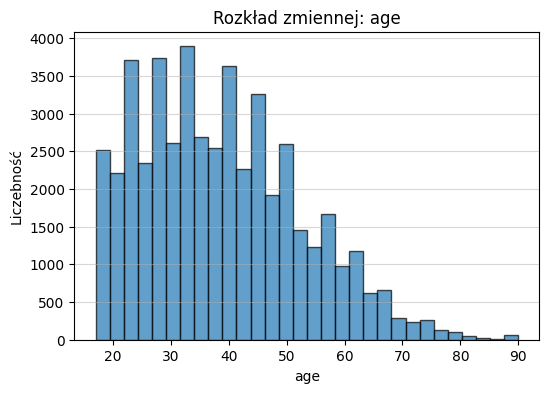

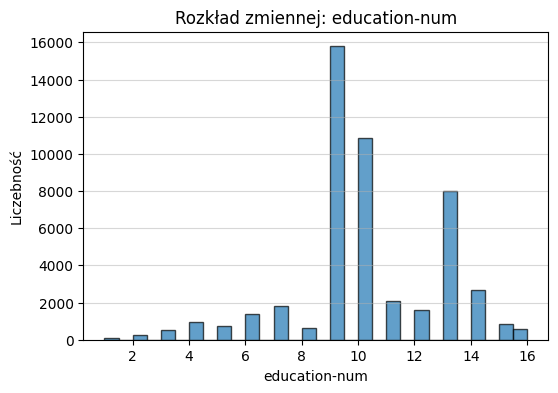

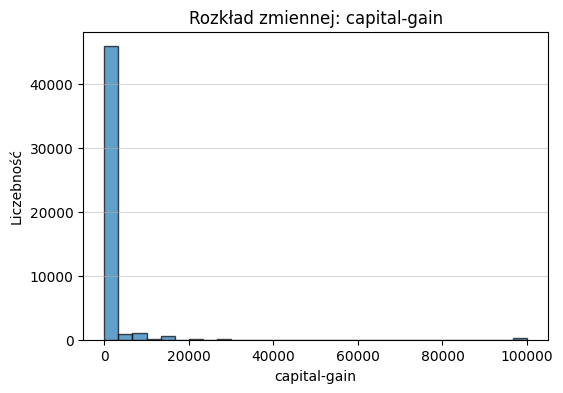

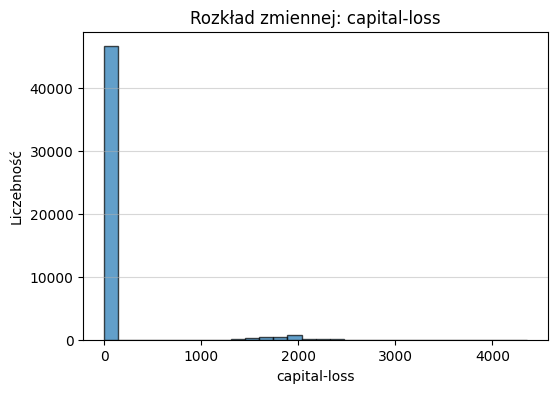

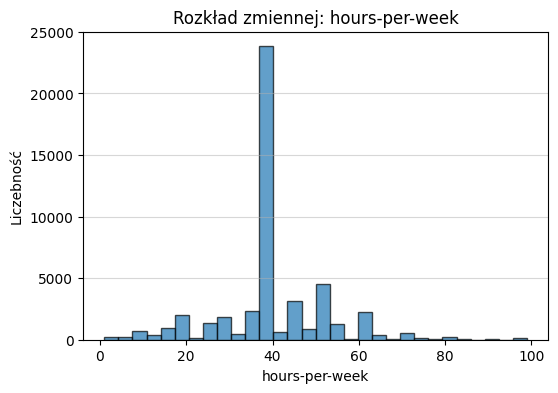

In [28]:
for col in ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']:
    plt.figure(figsize=(6, 4))
    plt.hist(df_adult[col], bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Rozkład zmiennej: {col}')
    plt.xlabel(col)
    plt.ylabel('Liczebność')
    plt.grid(axis='y', alpha=0.5)
    plt.show()

**Wnioski z analizy rozkładów:**

Wygenerowane histogramy ujawniają kluczowe charakterystyki populacji:
1.  **age:** Rozkład jest prawoskośny (przesunięty w stronę młodszych uczestników), z wyraźną dominacją osób w wieku produkcyjnym (20-50 lat).
2.  **education-num:** Rozkład wielomodalny. Wyraźne "piki" (słupki) odpowiadają momentom kończenia poszczególnych etapów edukacji (np. liceum - 9, licencjat - 13).
3.  **capital-gain / capital-loss:** Zmienne ekstremalnie skośne. Zdecydowana większość słupka znajduje się przy wartości 0, co oznacza, że większość ludzi nie ma zysków/strat kapitałowych.
4.  **hours-per-week:** Dominująca wartość (moda) to 40 godzin, co tworzy wielki słupek pośrodku wykresu, odzwierciedlając standardowy etat pracy.

#### 4.2. Rozkłady zmiennych kategorycznych

Poniżej przedstawiono rozkłady zmiennych kategorycznych w oryginalnym zbiorze danych (przed kodowaniem one-hot). Analiza ta pozwala zrozumieć strukturę populacji oraz zidentyfikować kategorie dominujące i rzadkie.

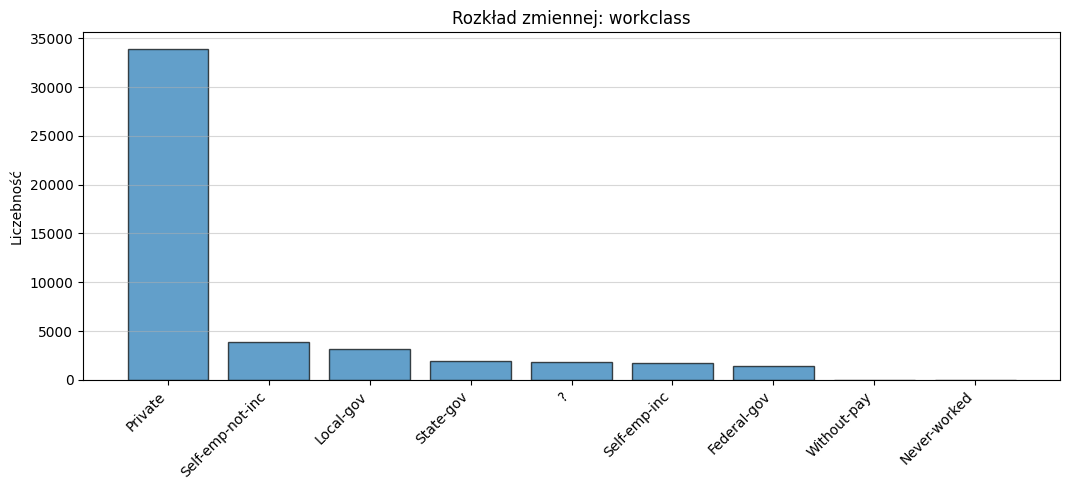

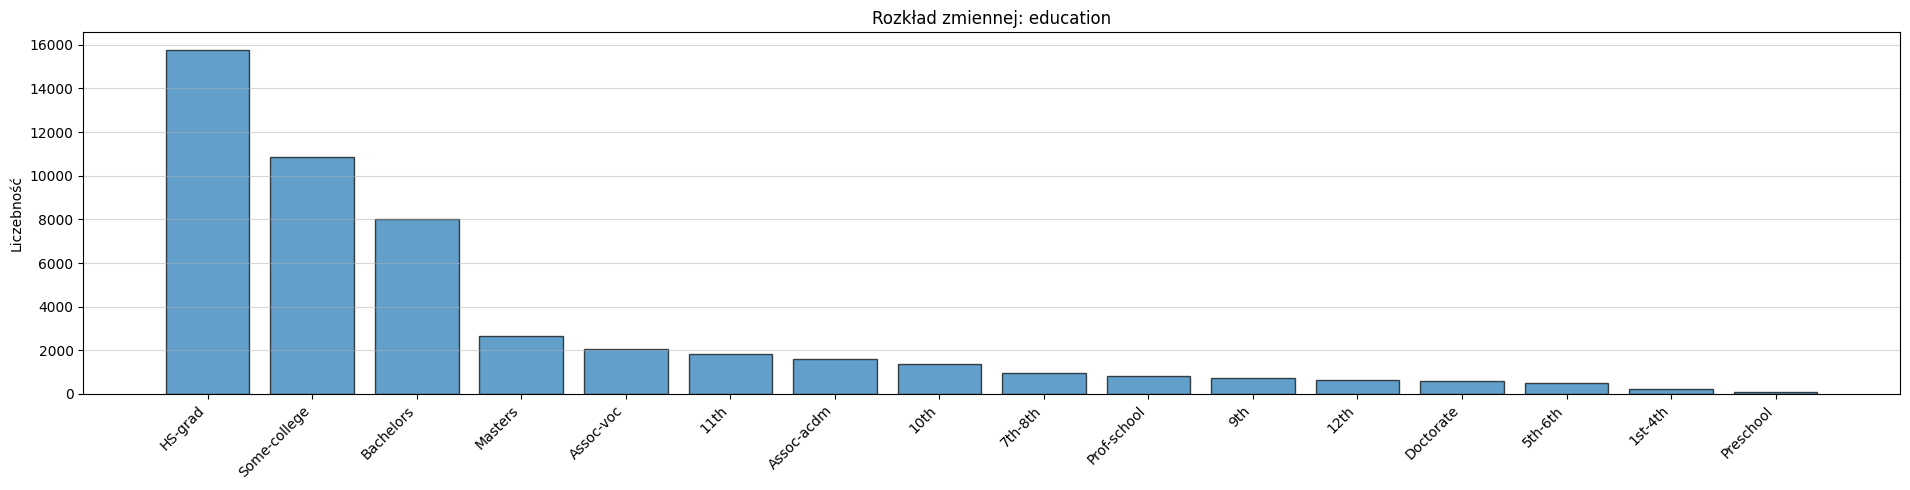

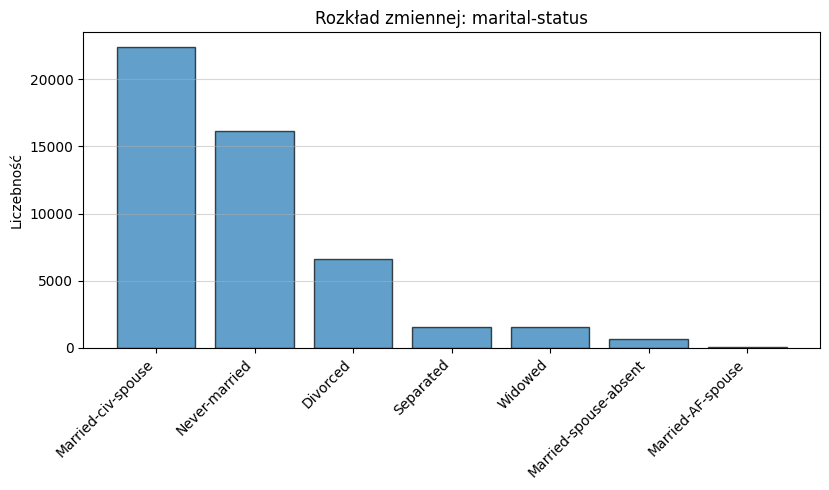

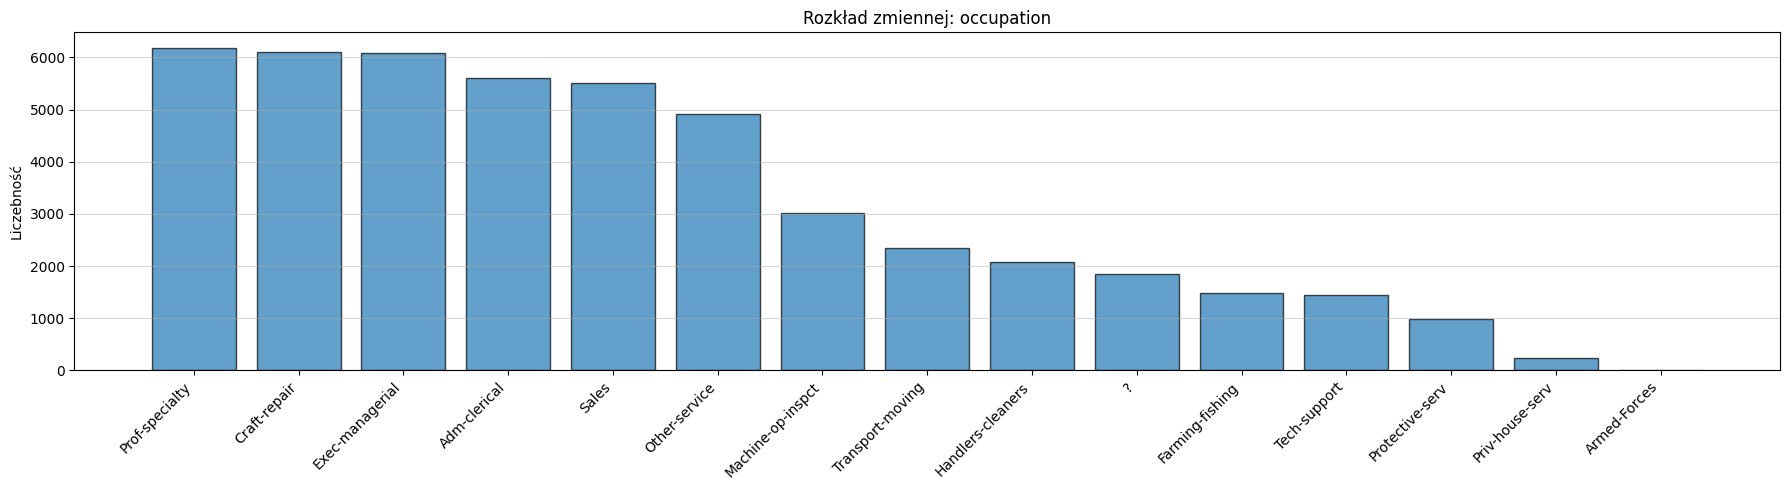

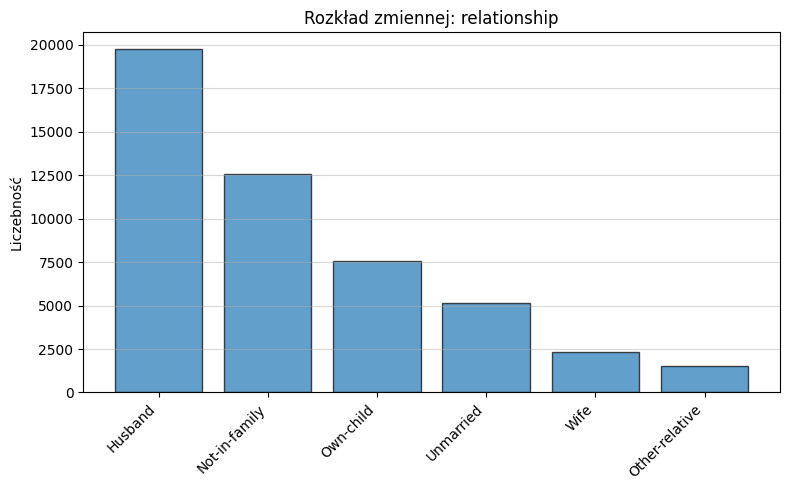

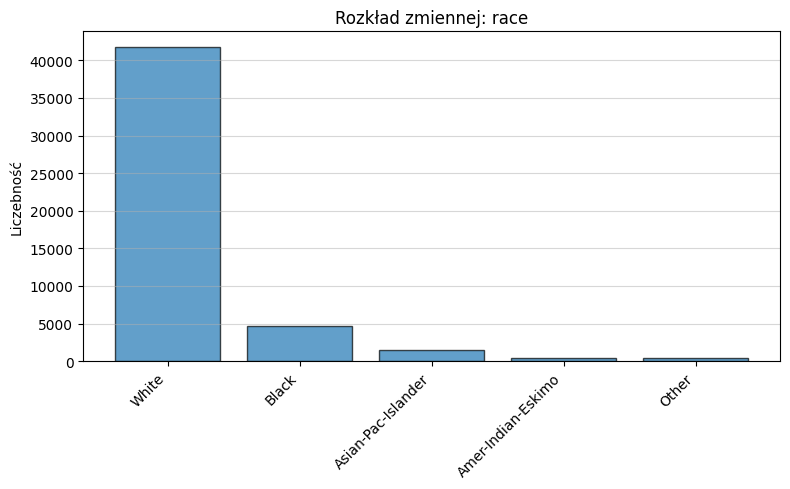

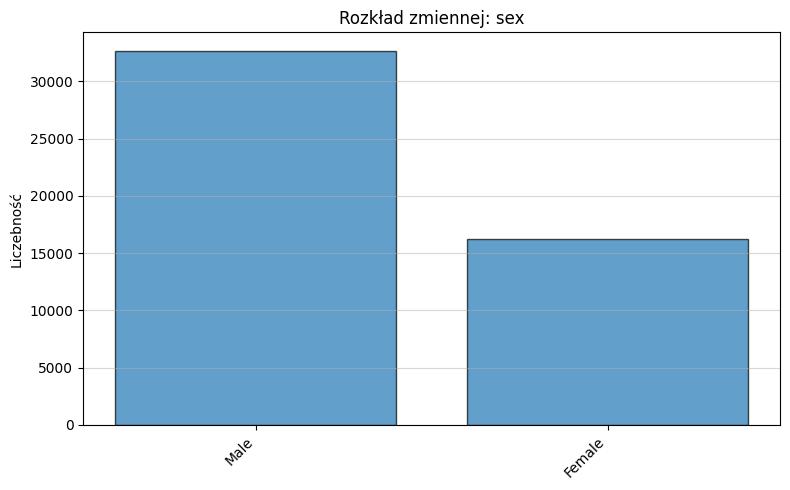

In [29]:
# Używamy oryginalnych danych z ucimlrepo (przed przetworzeniem)
X_original = adult.data.features

for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']:
    num_vals = len(X_original[col].dropna().unique())
    plt.figure(figsize=(max(num_vals * 1.2, 8), 5))
    counts = X_original[col].value_counts()
    plt.bar(x=range(len(counts)), height=counts.values, edgecolor='black', alpha=0.7)
    plt.title(f'Rozkład zmiennej: {col}')
    plt.xticks(range(len(counts)), counts.index, rotation=45, ha='right')
    plt.ylabel('Liczebność')
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

#### 4.3. Rozkład zmiennej celu: income
Zmienna celu 'income' jest niezbalansowana. 

In [30]:
target_names = ['<=50K', '>50K']

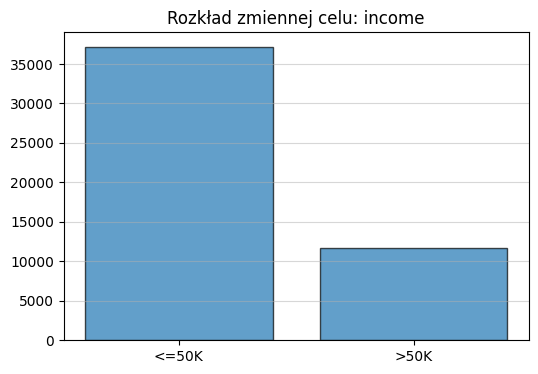

In [31]:
plt.figure(figsize=(6, 4))
plt.bar(x=df_adult['income_binary'].value_counts().index, height=df_adult['income_binary'].value_counts().values, edgecolor='black', alpha=0.7)
plt.xticks(df_adult['income_binary'].value_counts().index, labels=target_names)
plt.title(f'Rozkład zmiennej celu: income')
plt.grid(axis='y', alpha=0.5)
plt.show()

In [32]:
print(f"Stosunek klasy '<=50K' do '>50K': {df_adult['income_binary'].value_counts()[0] / df_adult['income_binary'].value_counts()[1]}")

Stosunek klasy '<=50K' do '>50K': 3.179173440574998


#### 4.4. Analiza korelacji
W celu znalezienia zależności między zmiennymi, wygenerowana została poniżej macierz korelacji. Ze względu na występowanie zmiennyh binarnych i kategorycznych, wykorzystana została korelacja rank Spearmana.

In [33]:
matrix = df_adult.corr(method='spearman')

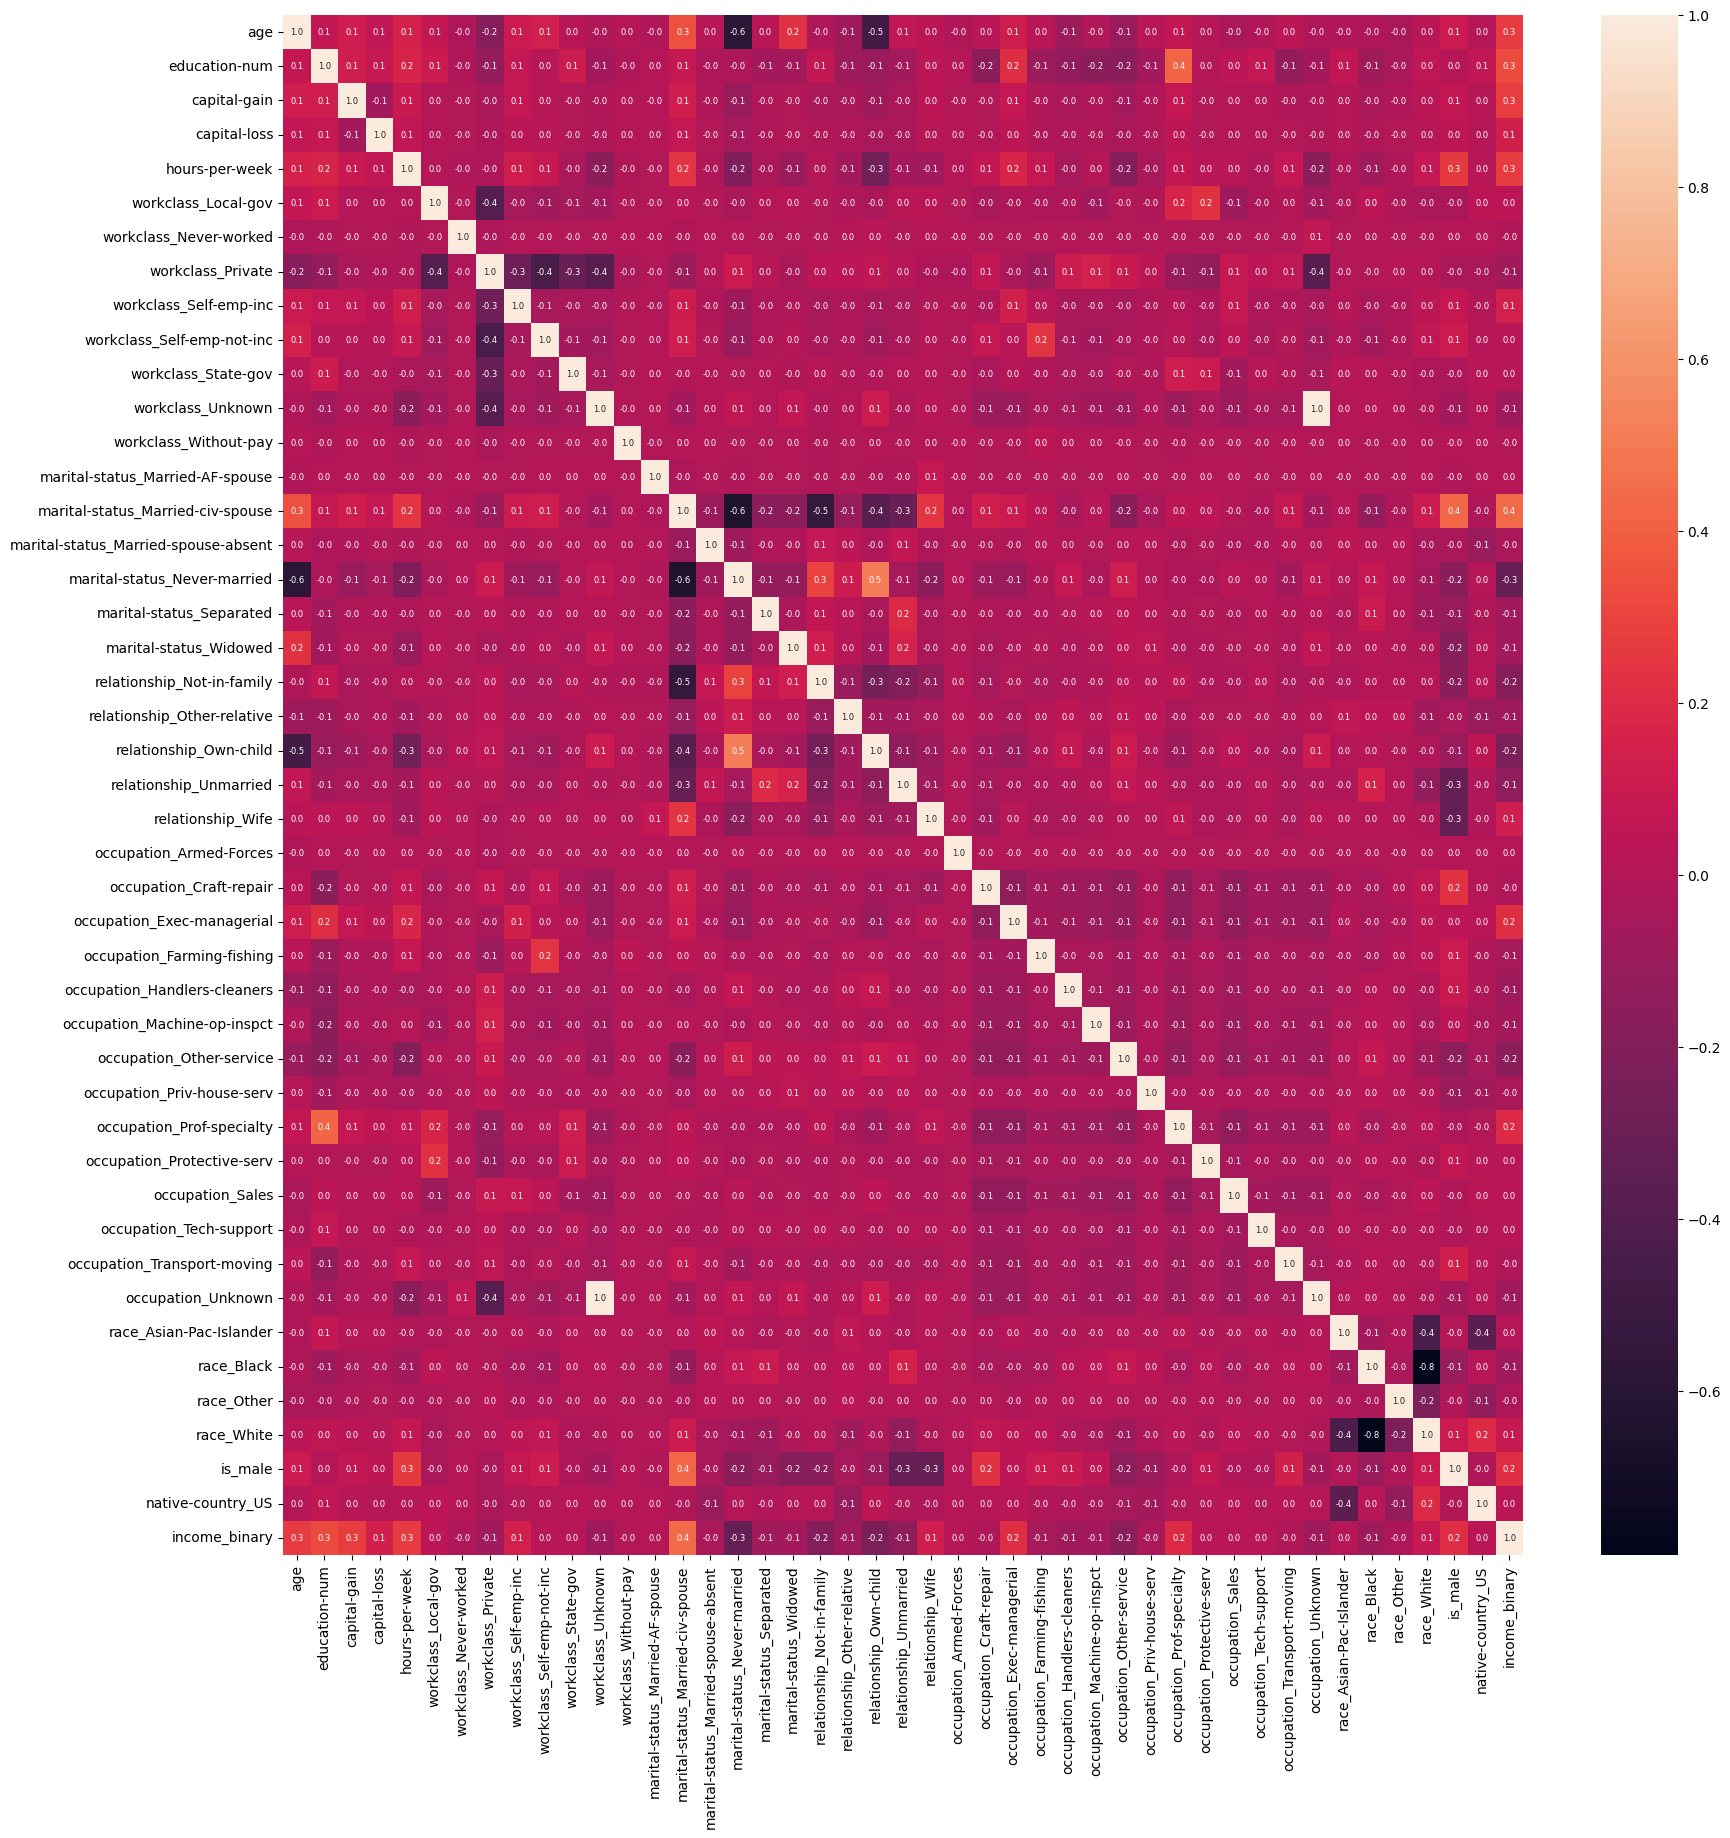

In [34]:
plt.figure(figsize=(20, 20))
sns.heatmap(matrix, xticklabels=matrix.columns.values, yticklabels=matrix.columns.values, annot=True, fmt='.1f', annot_kws={"size":6});
plt.show()

**Wnioski z analizy korelacji:**

**Korelacje między zmiennymi niezależnymi:**
- `workclass_Unknown` i `occupation_Unknown` = 1.0 (te same osoby mają braki w obu zmiennych)
- `marital-status_Married-civ-spouse` i `relationship_Husband` = 0.9 (naturalna zależność semantyczna)
- `race_Black` i `race_White` = -0.8 (wzajemne wykluczanie kategorii)

**Korelacje z zmienną celu (income_binary):**
- `marital-status_Married-civ-spouse` ~ 0.4 (osoby zamężne/żonate zarabiają więcej)
- `education-num` ~ 0.3 (wyższe wykształcenie = wyższy dochód)
- `age` ~ 0.2 (starsi zarabiają więcej)
- `hours-per-week` ~ 0.2 (więcej godzin pracy = wyższy dochód)
- `relationship_Own-child` ~ -0.2 (dzieci mieszkające z rodzicami zarabiają mniej)
- `marital-status_Never-married` ~ -0.3 (osoby niezamężne zarabiają mniej)


#### 4.5. Analiza zależności zmiennych od zmiennej celu

W tej sekcji zbadano, jak poszczególne zmienne różnicują grupy dochodowe. Celem jest identyfikacja cech o największej mocy dyskryminacyjnej, które będą kluczowe dla budowanych modeli klasyfikacyjnych.

##### 4.5.1. Zmienne numeryczne vs dochód

Wykresy pudełkowe (boxploty) pozwalają porównać rozkłady zmiennych numerycznych między grupami dochodowymi. Różnice w medianach i rozstępach międzykwartylowych wskazują na potencjalną moc predykcyjną zmiennej.

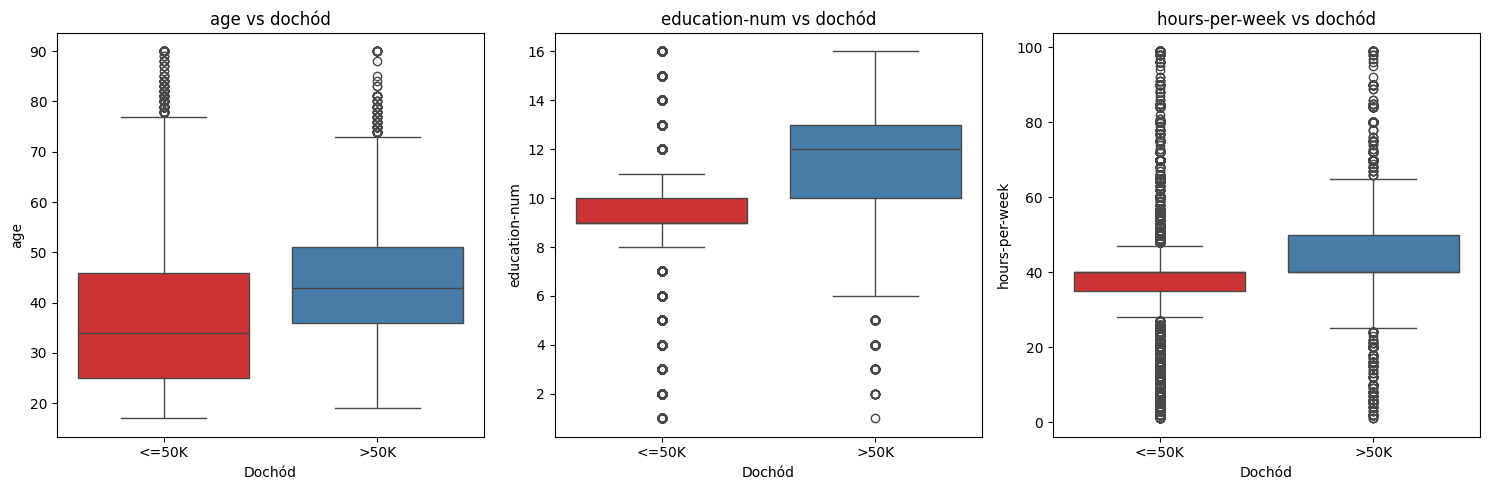

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(['age', 'education-num', 'hours-per-week']):
    sns.boxplot(x='income_binary', y=col, data=df_adult, ax=axes[i], hue='income_binary', palette='Set1', legend=False)
    axes[i].set_title(f'{col} vs dochód')
    axes[i].set_xticklabels(['<=50K', '>50K'])
    axes[i].set_xlabel('Dochód')

plt.tight_layout()
plt.show()

**Wnioski z analizy boxplotów:**

1. **age:** Mediana wieku dla grupy >50K (~44 lata) jest wyraźnie wyższa niż dla <=50K (~34 lata). Wyższy dochód wiąże się z większym doświadczeniem zawodowym.

2. **education-num:** Najsilniejsza separacja klas. Mediana dla >50K to ~13 (licencjat), dla <=50K to ~9 (szkoła średnia). Wykształcenie jest kluczowym predyktorem dochodu.

3. **hours-per-week:** Osoby zarabiające >50K pracują więcej (mediana ~45h) niż grupa <=50K (mediana ~40h). Wyższy dochód koreluje z większym zaangażowaniem czasowym.

##### 4.5.2. Zmienne kategoryczne vs dochód

Wykresy słupkowe przedstawiają odsetek osób zarabiających >50K w poszczególnych kategoriach. Pozwala to zidentyfikować grupy o najwyższym i najniższym prawdopodobieństwie wysokiego dochodu.

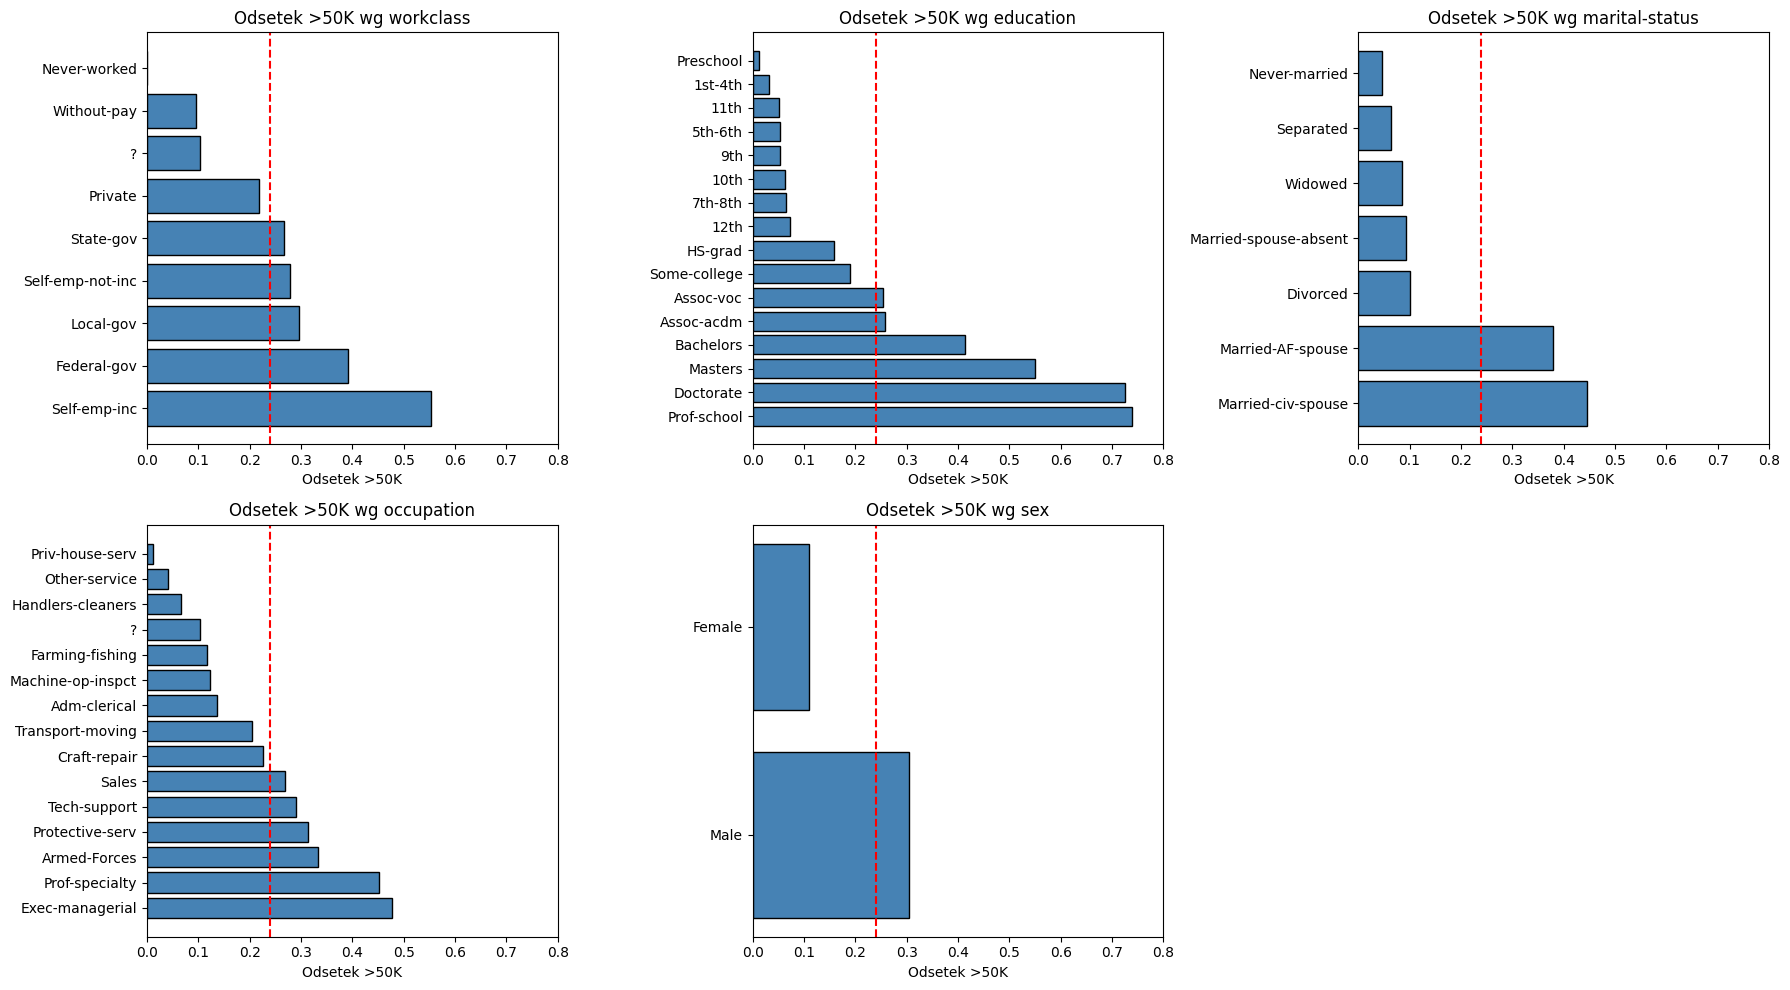

In [37]:
# Przygotowanie danych do analizy (oryginalne dane + zmienna celu)
df_analysis = adult.data.features.copy()
df_analysis['income'] = adult.data.targets
df_analysis['income_binary'] = df_analysis['income'].apply(lambda x: 1 if x in ('>50K', '>50K.') else 0)

cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'sex']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    # Oblicz % osób z >50K dla każdej kategorii
    pct_high_income = df_analysis.groupby(col)['income_binary'].mean().sort_values(ascending=False)
    
    axes[i].barh(range(len(pct_high_income)), pct_high_income.values, color='steelblue', edgecolor='black')
    axes[i].set_yticks(range(len(pct_high_income)))
    axes[i].set_yticklabels(pct_high_income.index)
    axes[i].set_xlabel('Odsetek >50K')
    axes[i].set_title(f'Odsetek >50K wg {col}')
    axes[i].axvline(x=0.24, color='red', linestyle='--', label='Średnia (24%)')
    axes[i].set_xlim(0, 0.8)

# Ukryj ostatni pusty subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

**Wnioski z analizy zmiennych kategorycznych:**

1. **education:** Najsilniejszy predyktor. Osoby z wykształceniem Prof-school (~75%) i Doctorate (~70%) mają najwyższe szanse na dochód >50K. Osoby bez matury (Preschool, 1st-4th) praktycznie nie osiągają wysokich dochodów.

2. **marital-status:** Osoby w związku małżeńskim (Married-civ-spouse) mają ~45% szans na >50K, podczas gdy osoby nigdy niezamężne tylko ~5%.

3. **occupation:** Exec-managerial i Prof-specialty mają najwyższy odsetek (~50%), podczas gdy prywatna służba domowa (Priv-house-serv) i rolnictwo mają najniższy.

4. **sex:** Mężczyźni mają znacznie wyższy odsetek >50K (~30%) niż kobiety (~11%), co odzwierciedla historyczne nierówności płacowe.

5. **workclass:** Self-emp-inc (samozatrudnieni z inkorporacją) mają najwyższy odsetek (~55%), co sugeruje, że przedsiębiorcy osiągają wyższe dochody.

### 5. Budowa modeli
W niniejszej sekcji przedstawiono proces budowy oraz strojenia modeli statystycznych zastosowanych do rozwiązania problemu klasyfikacji, zgodnie z założeniami projektu obejmującymi konstrukcję co najmniej trzech modeli oraz dobór ich hiperparametrów w celu uzyskania możliwie najlepszej jakości predykcji.

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report, accuracy_score, precision_score, recall_score, f1_score

# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import l1_min_c

import random
random.seed(42)

In [39]:
# podział zbioru na treningowy i testowy 
X = df_adult.drop(columns=['income_binary'])
y = df_adult['income_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standaryzacja zmiennych numerycznych (fit na train, transform na train i test)
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Ze względu na nierównowagę w liczebości klas zmiennej celu, można przetestować SMOTE

In [40]:
smote = SMOTE(random_state=42);
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train);

Funkcje pomocnicze

In [44]:
def plot_confusion_matrices(y_train, y_train_hat, y_test, y_test_hat):
    cm_train, cm_test = confusion_matrix(y_train, y_train_hat), confusion_matrix(y_test, y_test_hat)

    plt.figure(figsize=(10, 4))

    plt.subplot(1,2,1)
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Predicted 0", "Predicted 1"], 
                yticklabels=["Actual 0", "Actual 1"])
    plt.title("Train Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1,2,2)
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Predicted 0", "Predicted 1"], 
                yticklabels=["Actual 0", "Actual 1"])
    plt.title("Test Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()


def plot_roc_auc_curve(X_train, y_train, X_test, y_test, model):
    y_train_lr_proba = model.predict_proba(X_train)[:,1]
    fprt, tprt, _ = roc_curve(y_train, y_train_lr_proba)
    auc_roct = auc(fprt, tprt)

    y_test_lr_proba = model.predict_proba(X_test)[:,1]
    fprv, tprv, _ = roc_curve(y_test, y_test_lr_proba)
    auc_rocv = auc(fprv, tprv)

    plt.figure(figsize=(5, 4))

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC+AUC")

    plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random, AUC = 0.5")
    plt.plot([0, 0], [0, 1], color="navy", linestyle=":", label="Wizard, AUC = 1.0")
    plt.plot([0, 1], [1, 1], color="navy", linestyle=":")

    plt.plot(fprt, tprt, color="orange", label="Model - train, AUC = %0.2f" % auc_roct)
    plt.plot(fprv, tprv, color="red", label="Model - val, AUC = %0.2f" % auc_rocv)
    plt.legend(loc="lower right");

    plt.show()


def print_report(y_train, y_train_hat, y_test, y_test_hat, target_names):
    print("Training data:\n", classification_report(y_train, y_train_hat, target_names=target_names), "\n\nTest data:\n", classification_report(y_test, y_test_hat, target_names=target_names))

#### 5.1. Regresja logistyczna

In [ ]:
from sklearn.linear_model import LogisticRegression

##### 5.1.1. Podstawowy model - baseline
Ze względu na niezbalnsowanie zmiennej celu, zoastosowane zostaną 2 podejścia: SMOTE oraz class weights.

**Regresja logistyczna + SMOTE**

In [ ]:
lr_smote = LogisticRegression(random_state=42)
lr_smote.fit(X_train_smote, y_train_smote)

In [ ]:
y_train_lr_smote = lr_smote.predict(X_train)
y_test_lr_smote = lr_smote.predict(X_test)

In [ ]:
plot_confusion_matrices(y_train, y_train_lr_smote, y_test, y_test_lr_smote)
plot_roc_auc_curve(X_train, y_train, X_test, y_test, lr_smote)
print_report(y_train, y_train_lr_smote, y_test, y_test_lr_smote, target_names)

**Regresja logistyczna + class weight**

In [ ]:
# model ze zastosowaniem wag klas
lr_clas_weights = LogisticRegression(random_state=42, class_weight='balanced')
lr_clas_weights.fit(X_train, y_train)

In [ ]:
y_train_lr_cw = lr_clas_weights.predict(X_train)
y_test_lrcw = lr_clas_weights.predict(X_test)

In [ ]:
plot_confusion_matrices(y_train, y_train_lr_cw, y_test, y_test_lrcw)
plot_roc_auc_curve(X_train, y_train, X_test, y_test, lr_clas_weights)
print_report(y_train, y_train_lr_cw, y_test, y_test_lrcw, target_names)

##### 5.1.2. Dobór parametrów do modelu
Przy pomocy Grid Search dobrane zostaną wartości:
- C: od 0 do 10
- penalty: brak, L1, L2, L1+L2 (elastic net)

Ze względu na występowanie zmiennych binarnych (na wskutek one-hot encoding), najlepszym solverem będzie 'saga'.

In [ ]:
lr = LogisticRegression(solver="saga", class_weight='balanced', max_iter=1000, random_state=42)

C_grid = np.logspace(-3, 1, 7) # np.linspace(0.01, 10, 100)
penalty = [None] # [None, "l1", "l2", "elasticnet"]
param_grid = {"penalty": penalty, "C": C_grid}

In [ ]:
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring="accuracy",
    cv=8,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

In [ ]:
print("GridSearchCV best parameters")
print(f"C:\t\t{grid_search.best_params_['C']}")
print(f"penalty:\t{grid_search.best_params_['penalty']}")

print("\nBest scores")
print(f"GridSearch:\t{grid_search.best_score_:.10f}")

#### 5.2. Las losowy

#### 5.3. XGBoost

XGBoost (Extreme Gradient Boosting) to zaawansowany algorytm oparty na metodzie wzmacniania gradientowego (gradient boosting). Buduje sekwencyjnie drzewa decyzyjne, gdzie każde kolejne drzewo koryguje błędy poprzednich. XGBoost jest znany z wysokiej skuteczności w zadaniach klasyfikacji tabelarycznej oraz wbudowanej obsługi niezbalansowania klas poprzez parametr `scale_pos_weight`.

In [41]:
from xgboost import XGBClassifier

# Obliczenie wagi dla klasy mniejszościowej (obsługa niezbalansowania)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 3.20


##### 5.3.1. Model bazowy XGBoost

Najpierw trenujemy model z domyślnymi parametrami, aby ustalić baseline do porównania z modelem po tuningu.

In [42]:
# Model bazowy XGBoost
xgb_baseline = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_baseline.fit(X_train, y_train)

# Predykcje
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)

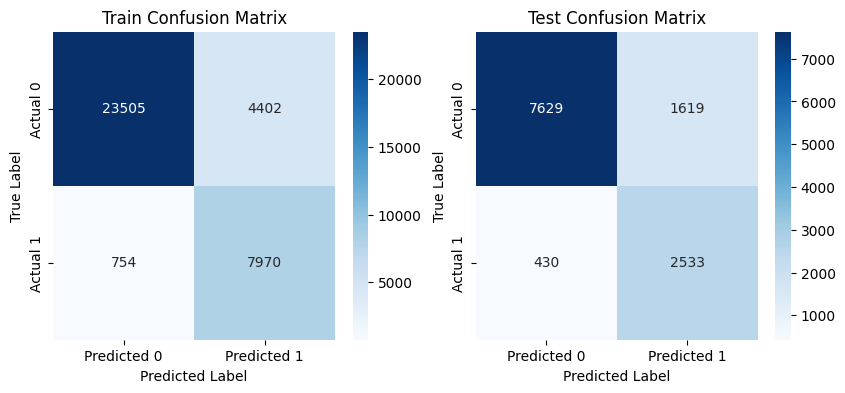

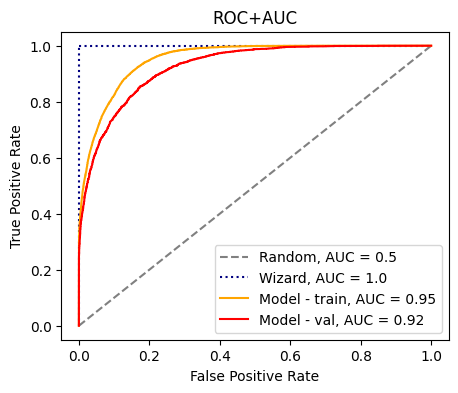

Training data:
               precision    recall  f1-score   support

       <=50K       0.97      0.84      0.90     27907
        >50K       0.64      0.91      0.76      8724

    accuracy                           0.86     36631
   macro avg       0.81      0.88      0.83     36631
weighted avg       0.89      0.86      0.87     36631
 

Test data:
               precision    recall  f1-score   support

       <=50K       0.95      0.82      0.88      9248
        >50K       0.61      0.85      0.71      2963

    accuracy                           0.83     12211
   macro avg       0.78      0.84      0.80     12211
weighted avg       0.86      0.83      0.84     12211



In [45]:
# Ewaluacja modelu bazowego
plot_confusion_matrices(y_train, y_train_xgb_base, y_test, y_test_xgb_base)
plot_roc_auc_curve(X_train, y_train, X_test, y_test, xgb_baseline)
print_report(y_train, y_train_xgb_base, y_test, y_test_xgb_base, target_names)

##### 5.3.2. Tuning hiperparametrów

Do optymalizacji hiperparametrów wykorzystano GridSearchCV z walidacją krzyżową (5-fold). Przeszukiwane parametry:
- **n_estimators**: liczba drzew (50, 100, 200)
- **max_depth**: maksymalna głębokość drzewa (3, 5, 7)
- **learning_rate**: współczynnik uczenia (0.01, 0.1, 0.2)
- **subsample**: frakcja próbek do budowy każdego drzewa (0.8, 1.0)
- **colsample_bytree**: frakcja cech do budowy każdego drzewa (0.8, 1.0)

In [46]:
# Definicja siatki hiperparametrów
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Model bazowy do tuningu
xgb_base = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# GridSearchCV
xgb_grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    scoring='f1',  # F1-score ze względu na niezbalansowanie klas
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Rozpoczęcie GridSearchCV dla XGBoost...")
print(f"Liczba kombinacji: {3*3*3*2*2} = 108")
xgb_grid_search.fit(X_train, y_train)

Rozpoczęcie GridSearchCV dla XGBoost...
Liczba kombinacji: 108 = 108
Fitting 5 folds for each of 108 candidates, totalling 540 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [50, 100, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and 

In [48]:
print("NAJLEPSZE HIPERPARAMETRY XGBoost:")
for param, value in xgb_grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nNajlepszy wynik F1 (CV): {xgb_grid_search.best_score_:.4f}")

NAJLEPSZE HIPERPARAMETRY XGBoost:
  colsample_bytree: 1.0
  learning_rate: 0.2
  max_depth: 5
  n_estimators: 200
  subsample: 1.0

Najlepszy wynik F1 (CV): 0.7165


##### 5.3.3. Ewaluacja najlepszego modelu XGBoost

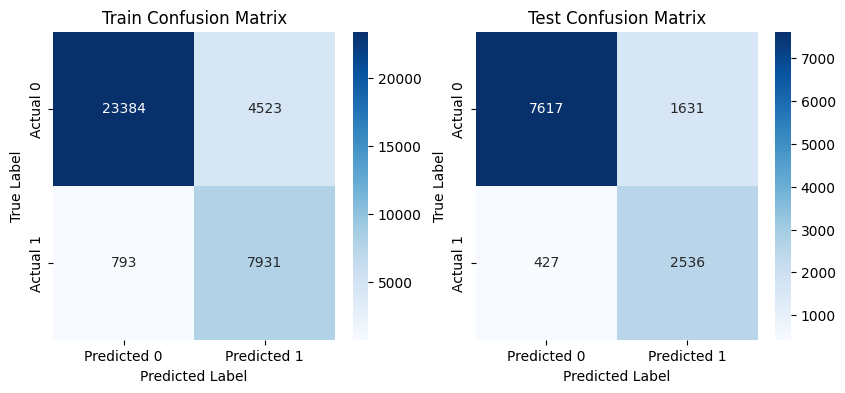

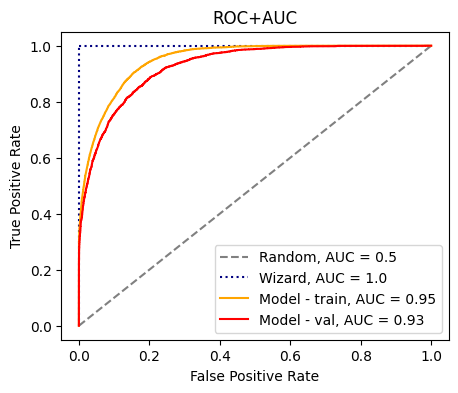

Training data:
               precision    recall  f1-score   support

       <=50K       0.97      0.84      0.90     27907
        >50K       0.64      0.91      0.75      8724

    accuracy                           0.85     36631
   macro avg       0.80      0.87      0.82     36631
weighted avg       0.89      0.85      0.86     36631
 

Test data:
               precision    recall  f1-score   support

       <=50K       0.95      0.82      0.88      9248
        >50K       0.61      0.86      0.71      2963

    accuracy                           0.83     12211
   macro avg       0.78      0.84      0.80     12211
weighted avg       0.86      0.83      0.84     12211



In [49]:
# Najlepszy model
xgb_best = xgb_grid_search.best_estimator_

# Predykcje
y_train_xgb_best = xgb_best.predict(X_train)
y_test_xgb_best = xgb_best.predict(X_test)

# Ewaluacja
plot_confusion_matrices(y_train, y_train_xgb_best, y_test, y_test_xgb_best)
plot_roc_auc_curve(X_train, y_train, X_test, y_test, xgb_best)
print_report(y_train, y_train_xgb_best, y_test, y_test_xgb_best, target_names)

##### 5.3.4. Ważność cech (Feature Importance)

XGBoost umożliwia analizę ważności cech, co pozwala zidentyfikować zmienne o największym wpływie na predykcję dochodu.

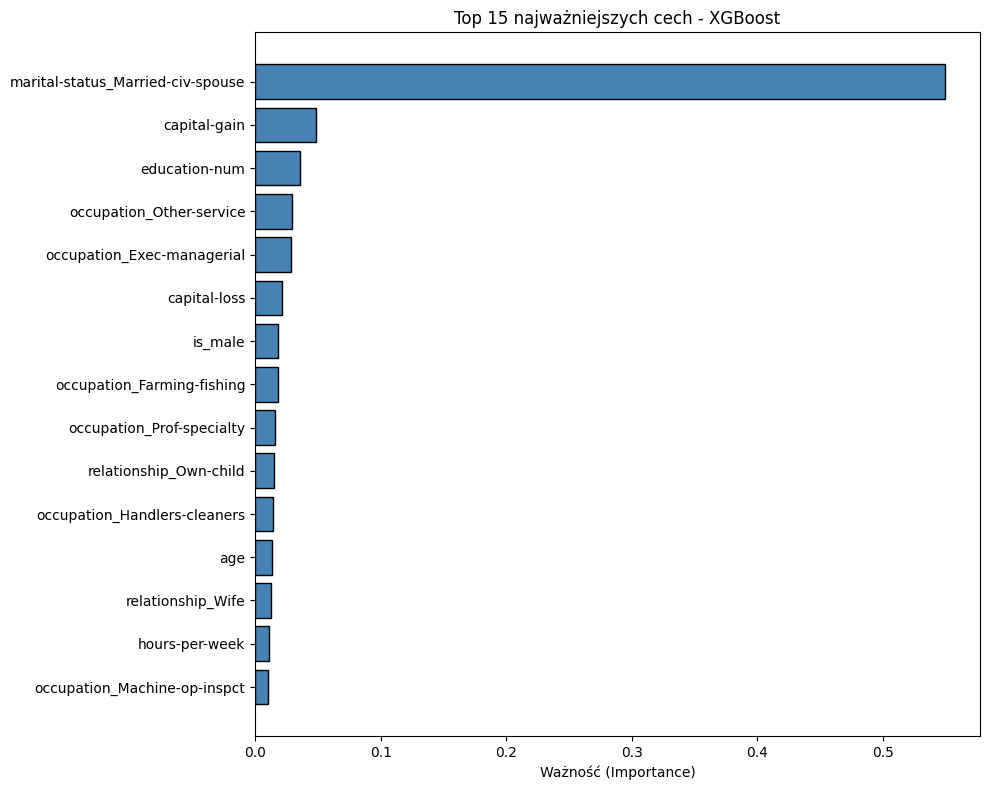


Top 10 najważniejszych cech:
                          feature  importance
marital-status_Married-civ-spouse    0.549887
                     capital-gain    0.048793
                    education-num    0.035941
         occupation_Other-service    0.029299
       occupation_Exec-managerial    0.028438
                     capital-loss    0.021112
                          is_male    0.018444
       occupation_Farming-fishing    0.018391
        occupation_Prof-specialty    0.015740
           relationship_Own-child    0.014773


In [50]:
# Ważność cech
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)

# Wykres top 15 najważniejszych cech
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Ważność (Importance)')
plt.title('Top 15 najważniejszych cech - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 najważniejszych cech:")
print(feature_importance.head(10).to_string(index=False))

**Podsumowanie modelu XGBoost:**

Model XGBoost po tuningu hiperparametrów wykazuje wysoką skuteczność w klasyfikacji dochodu. Analiza ważności cech potwierdza wcześniejsze obserwacje z EDA - zmienne takie jak `marital-status`, `education-num`, `age` oraz `capital-gain` mają największy wpływ na predykcję. Model dobrze radzi sobie z niezbalansowaniem klas dzięki zastosowaniu parametru `scale_pos_weight`.

### 6. Ocena i wybór najlepszego modelu
Graficzna i opisowa ocena oraz wybór modelu

### 7. Podsumowanie
Podsumowanie wyników, dyskusja na temat napotkanych problemów, wyzwań i zastosowanych rozwiązań